In [38]:
import mlflow
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import NullFormatter, FormatStrFormatter, ScalarFormatter
import tikzplotlib
import pandas as pd

from matplotlib import rc
rc('font',**{'family':'libertine'})
rc('text', usetex=True)


import seaborn as sns

import sys
sys.path.append('../')

from src import DATA_PATH, ROOT_PATH
DATA_PATH = f'{DATA_PATH}/OCT2017'
FIGURES_PATH = f'{ROOT_PATH}/reports/figures'

mlflow.set_tracking_uri('http://localhost:5001')

In [39]:
runs = mlflow.search_runs(filter_string=f"tags.type_of_run = 'varying_number_of_labels'",
                                           run_view_type=mlflow.tracking.client.ViewType.ACTIVE_ONLY,
                                           experiment_ids=[1, 2, 4])
runs['params.n_labels_train'] = runs['params.n_labels_train'].astype(int)
runs['params.patience'] = runs.apply(lambda row: row['params.early_stopping_patience'] if row['params.early_stopping'] is None 
                                     else eval(row['params.early_stopping'])['patience'], 
                                     axis=1).astype(int)
runs['params.epochs'] = runs['params.epochs'].astype(int)


In [40]:
runs = runs[~runs.end_time.isna()]
# runs = runs[(runs['params.epochs'] == runs['params.patience']) | (runs['experiment_id'] == '2')]

In [41]:
best_full_supervised = mlflow.search_runs(filter_string="params.split_lab_unlab = 'False'",
                                          experiment_ids=[2], 
                                          run_view_type=mlflow.tracking.client.ViewType.ACTIVE_ONLY)

In [42]:
best_full_supervised_acc = best_full_supervised['metrics.acc_top1'].max()
best_full_supervised_acc *= 0.01

In [43]:
best_full_supervised_acc

0.9968750000000001

## Top algorithms

In [44]:
grouped_max = runs.groupby(['experiment_id', 'params.n_labels_train'])['metrics.acc_top1'].agg([max, min, 'mean', len])
grouped_max = grouped_max.stack()
grouped_max = grouped_max.rename('value')
grouped_max.index = grouped_max.index.rename('agg', level=2)
grouped_max = grouped_max.reset_index()

grouped_max['params.n_labels_train'] = grouped_max['params.n_labels_train'].astype(int)
grouped_max['experiment_id'] = grouped_max['experiment_id'].map({'1': 'Mix-Match', 
                                                                 '2': 'Transfer Learning', 
                                                                 '4': 'Fix-Match'})
grouped_max.value *= 0.01

INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


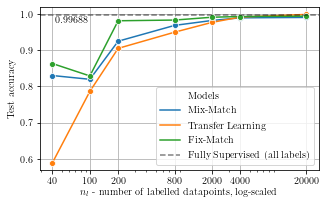

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

g = sns.lineplot(x="params.n_labels_train", y="value", hue="experiment_id",
                 data=grouped_max[grouped_max['agg'] == 'max'], marker='o', ax=ax)
ax.axhline(best_full_supervised_acc, alpha=0.5, color='black', linestyle='--', label='Fully Supervised (all labels)')
ax.text(43, best_full_supervised_acc-0.02, f'{best_full_supervised_acc:.5f}')
ax.set_xscale('log')
# ax.set_yscale('logit')
ax.set_xticks(sorted(grouped_max['params.n_labels_train'].unique()))

ax.get_xaxis().set_major_formatter(ScalarFormatter())
# ax.get_yaxis().set_major_formatter(FormatStrFormatter('%g'))
# ax.get_yaxis().set_minor_formatter(NullFormatter())
# ax.get_yaxis().set_ticks([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 0.995, 0.9995, 0.999])

ax.set_xlabel('$n_l$ - number of labelled datapoints, log-scaled')
ax.set_ylabel('Test accuracy')

ax.legend().texts[0].set_text("Models")
plt.grid()
plt.savefig(f'{FIGURES_PATH}/best_models.pdf')

## Top transfer learning

In [46]:
param_name = 'params.freeze_layers'
# param_name = 'params.lr'
# param_name = 'params.ema_decay'


transfer_max = runs[runs['experiment_id'] == '2'].groupby(['params.n_labels_train', param_name])['metrics.acc_top1'].agg([max])
transfer_max = transfer_max.stack()
transfer_max = transfer_max.rename('value')
transfer_max.index = transfer_max.index.rename('agg', level=2)
transfer_max = transfer_max.reset_index()

transfer_max['params.n_labels_train'] = transfer_max['params.n_labels_train'].astype(int)
transfer_max.value *= 0.01
transfer_max[param_name] = transfer_max[param_name].astype('category')

transfer_max['params.freeze_layers'] = transfer_max['params.freeze_layers'].map({'False': 'Fine-tuning', 
                                                                                 'True': 'Feature extraction'})


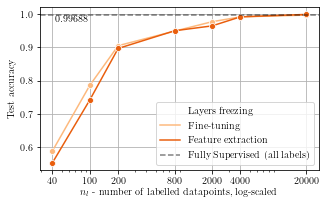

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

g = sns.lineplot(x="params.n_labels_train", y="value", hue=param_name, palette="Oranges",
                 data=transfer_max, marker='o', ax=ax)
ax.axhline(best_full_supervised_acc, alpha=0.5, color='black', linestyle='--', label='Fully Supervised (all labels)')
ax.text(43, best_full_supervised_acc-0.02, f'{best_full_supervised_acc:.5f}')
ax.set_xscale('log')
ax.set_xticks(sorted(transfer_max['params.n_labels_train'].unique()))

ax.get_xaxis().set_major_formatter(ScalarFormatter())

ax.set_xlabel('$n_l$ - number of labelled datapoints, log-scaled')
ax.set_ylabel('Test accuracy')

ax.legend().texts[0].set_text("Layers freezing")
plt.grid()
plt.savefig(f'{FIGURES_PATH}/transfer_learning_freezing.pdf')

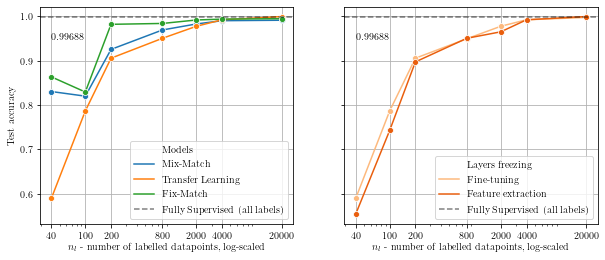

In [48]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey = True)
g = sns.lineplot(x="params.n_labels_train", y="value", hue="experiment_id",
                 data=grouped_max[grouped_max['agg'] == 'max'], marker='o', ax=ax[0])
ax[0].axhline(best_full_supervised_acc, alpha=0.5, color='black', linestyle='--', label='Fully Supervised (all labels)')
ax[0].text(40, best_full_supervised_acc-0.05, f'{best_full_supervised_acc:.5f}')
ax[0].set_xscale('log')
ax[0].set_xticks(sorted(grouped_max['params.n_labels_train'].unique()))

ax[0].get_xaxis().set_major_formatter(ScalarFormatter())

ax[0].set_xlabel('$n_l$ - number of labelled datapoints, log-scaled')
ax[0].set_ylabel('Test accuracy')

ax[0].legend().texts[0].set_text("Models")

g = sns.lineplot(x="params.n_labels_train", y="value", hue=param_name, palette="Oranges",
                 data=transfer_max, marker='o', ax=ax[1])
ax[1].axhline(best_full_supervised_acc, alpha=0.5, color='black', linestyle='--', label='Fully Supervised (all labels)')
ax[1].text(40, best_full_supervised_acc-0.05, f'{best_full_supervised_acc:.5f}')
ax[1].set_xscale('log')
ax[1].set_xticks(sorted(transfer_max['params.n_labels_train'].unique()))

ax[1].get_xaxis().set_major_formatter(ScalarFormatter())

ax[1].set_xlabel('$n_l$ - number of labelled datapoints, log-scaled')
ax[1].set_ylabel('Test accuracy')

ax[1].legend().texts[0].set_text("Layers freezing")

ax[0].grid()
ax[1].grid()
plt.savefig(f'{FIGURES_PATH}/performances.pdf')


## EMA decay study

In [49]:

grouped_ema = runs.groupby(['experiment_id', 'params.n_labels_train', 'params.ema_decay'])['metrics.acc_top1'].agg([max])

grouped_ema = grouped_ema.stack()
grouped_ema = grouped_ema.rename('value')
# grouped_ema *= 0.01
grouped_ema.index = grouped_ema.index.rename('agg', level=3)
grouped_ema.index = grouped_ema.index.droplevel(level = 3)
grouped_ema = grouped_ema.unstack(level=[1, 2])

grouped_ema.index = grouped_ema.index.map({'1': 'Mix-Match', '2': 'Transfer Learning', '4': 'Fix-Match'})

grouped_ema.columns.names = ['$n_l$', 'EMA decay']
grouped_ema = grouped_ema.round(2)
grouped_ema.index.name = 'Models'
grouped_ema


$n_l$              40            100           200           800           \
EMA decay            0.0  0.999    0.0  0.999    0.0  0.999    0.0  0.999   
Models                                                                      
Mix-Match          83.02  55.00  75.73  81.98  92.50  88.85  94.69  96.88   
Transfer Learning  58.96  37.92  78.65  40.10  90.52  53.23  95.00  77.92   
Fix-Match          86.33  72.66  82.91  75.88  97.07  98.14  98.34  98.05   

$n_l$              2000          4000          20000         
EMA decay            0.0  0.999    0.0  0.999    0.0  0.999  
Models                                                       
Mix-Match          98.02  98.23  98.02  98.96  99.06  98.75  
Transfer Learning  97.71  97.60  98.23  99.17  99.38  99.90  
Fix-Match          97.85  99.12  98.34  99.32  98.63  99.41

In [51]:
print(grouped_ema.to_latex(bold_rows=False))

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
\$n\_l\$ & \multicolumn{2}{l}{40} & \multicolumn{2}{l}{100} & \multicolumn{2}{l}{200} & \multicolumn{2}{l}{800} & \multicolumn{2}{l}{2000} & \multicolumn{2}{l}{4000} & \multicolumn{2}{l}{20000} \\
EMA decay &    0.0 &  0.999 &    0.0 &  0.999 &    0.0 &  0.999 &    0.0 &  0.999 &    0.0 &  0.999 &    0.0 &  0.999 &    0.0 &  0.999 \\
Models            &        &        &        &        &        &        &        &        &        &        &        &        &        &        \\
\midrule
Mix-Match         &  83.02 &  55.00 &  75.73 &  81.98 &  92.50 &  88.85 &  94.69 &  96.88 &  98.02 &  98.23 &  98.02 &  98.96 &  99.06 &  98.75 \\
Transfer Learning &  58.96 &  37.92 &  78.65 &  40.10 &  90.52 &  53.23 &  95.00 &  77.92 &  97.71 &  97.60 &  98.23 &  99.17 &  99.38 &  99.90 \\
Fix-Match         &  86.33 &  72.66 &  82.91 &  75.88 &  97.07 &  98.14 &  98.34 &  98.05 &  97.85 &  99.12 &  98.34 &  99.32 &  98.63 &  99.41 \\
\bottomrule
\end{tabular}

In [52]:
print(grouped_ema[[40, 100, 200, 800]].to_latex(bold_rows=False))

\begin{tabular}{lrrrrrrrr}
\toprule
\$n\_l\$ & \multicolumn{2}{l}{40} & \multicolumn{2}{l}{100} & \multicolumn{2}{l}{200} & \multicolumn{2}{l}{800} \\
EMA decay &    0.0 &  0.999 &    0.0 &  0.999 &    0.0 &  0.999 &    0.0 &  0.999 \\
Models            &        &        &        &        &        &        &        &        \\
\midrule
Mix-Match         &  83.02 &  55.00 &  75.73 &  81.98 &  92.50 &  88.85 &  94.69 &  96.88 \\
Transfer Learning &  58.96 &  37.92 &  78.65 &  40.10 &  90.52 &  53.23 &  95.00 &  77.92 \\
Fix-Match         &  86.33 &  72.66 &  82.91 &  75.88 &  97.07 &  98.14 &  98.34 &  98.05 \\
\bottomrule
\end{tabular}



In [53]:
print(grouped_ema[[2000, 4000, 20000]].to_latex(bold_rows=False))

\begin{tabular}{lrrrrrr}
\toprule
\$n\_l\$ & \multicolumn{2}{l}{2000} & \multicolumn{2}{l}{4000} & \multicolumn{2}{l}{20000} \\
EMA decay &    0.0 &  0.999 &    0.0 &  0.999 &    0.0 &  0.999 \\
Models            &        &        &        &        &        &        \\
\midrule
Mix-Match         &  98.02 &  98.23 &  98.02 &  98.96 &  99.06 &  98.75 \\
Transfer Learning &  97.71 &  97.60 &  98.23 &  99.17 &  99.38 &  99.90 \\
Fix-Match         &  97.85 &  99.12 &  98.34 &  99.32 &  98.63 &  99.41 \\
\bottomrule
\end{tabular}



## Running times

In [54]:
finished_runs = runs[~runs.end_time.isna()]
finished_runs['duration'] = finished_runs.end_time - finished_runs.start_time

In [55]:
# finished_runs.drop_duplicates()

In [56]:
times = finished_runs.sort_values('metrics.acc_top1', ascending=False).\
    groupby(['experiment_id', 'params.n_labels_train'])['duration'].agg(['first'])

# times = times.stack()
# times = times.rename('duration')
# times.columns = ['duration']
times = times.unstack(level=1)
times = times.droplevel(0, axis=1)
# times = times.reset_index()

# grouped_max['params.n_labels_train'] = grouped_max['params.n_labels_train'].astype(int)
times.index = times.index.map({'1': 'Mix-Match', '2': 'Transfer Learning', '4': 'Fix-Match'})
times.columns.names = ['$n_l$']
times.index.name = 'Models'
times

$n_l$,40,100,200,800,2000,4000,20000
Models,,,,,,,
Mix-Match,1 days 16:05:42.762000,0 days 09:12:09.851000,0 days 06:13:50.159000,02:30:29.069000,02:37:38.403000,02:24:19.021000,02:26:40.044000
Transfer Learning,0 days 00:10:38.599000,0 days 00:09:49.362000,0 days 00:12:15.652000,00:15:21.014000,00:24:53.473000,00:33:37.902000,01:39:14.940000
Fix-Match,5 days 09:36:35.105000,1 days 19:04:12.710000,1 days 00:40:55.927000,09:58:35.784000,10:40:04.375000,09:50:57.640000,07:51:53.439000


In [57]:
def strfdelta(tdelta, fmt_dict):
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    if d["days"] == 0:
        fmt_dict.pop('days')
    if d["hours"] == 0:
        fmt_dict.pop('hours')
    return ''.join([fmt.format(**d) for fmt in fmt_dict.values()])

In [58]:
times = times.applymap(lambda val: strfdelta(val, {'days': '{days}d ', 'hours': '{hours}h ', 'minutes': '{minutes}m '}))

In [59]:
print(times.to_latex(bold_rows=False))

\begin{tabular}{llllllll}
\toprule
\$n\_l\$ &       40    &       100   &    200   &    800   &     2000  &    4000  &    20000 \\
Models            &             &             &          &          &           &          &          \\
\midrule
Mix-Match         &  1d 16h 5m  &     9h 12m  &  6h 13m  &  2h 30m  &   2h 37m  &  2h 24m  &  2h 26m  \\
Transfer Learning &        10m  &         9m  &     12m  &     15m  &      24m  &     33m  &  1h 39m  \\
Fix-Match         &  5d 9h 36m  &  1d 19h 4m  &  1d 40m  &  9h 58m  &  10h 40m  &  9h 50m  &  7h 51m  \\
\bottomrule
\end{tabular}

